<a href="https://colab.research.google.com/github/BragaGiu/projeto-telecom-X-parte-2/blob/main/TelecomX_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar bibliotecas

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import requests
import gdown
from IPython.display import display, HTML

# Carregamento base de dados

In [4]:
df = pd.read_csv('/content/dados_tratados.csv')

In [5]:
df.head()

,Churn,genero_cliente,maior_65_anos,possui_parceiro,dependentes,tempo_contrato_meses,servico_telefonico,mais_de_uma_linha_telefonica,servico_internet,servico_seguranca_online,...,tipo_contrato,fatura_online,forma_de_pagamento,cobranca_mensal,cobranca_total,conta_diaria,Idoso,tempo_contrato_faixa,Churn_num,num_servicos
0,0,Female,0,1,1,9,1,No,DSL,No,...,One year,1,Mailed check,65.6,593.30,2.186667,Menor 65,0-12,0,3
1,0,Male,0,0,0,9,1,Yes,DSL,No,...,Month-to-month,0,Mailed check,59.9,542.40,1.996667,Menor 65,0-12,0,2
2,1,Male,0,0,0,4,1,No,Fiber optic,No,...,Month-to-month,1,Electronic check,73.9,280.85,2.463333,Menor 65,0-12,1,1
3,1,Male,1,1,0,13,1,No,Fiber optic,No,...,Month-to-month,1,Electronic check,98.0,1237.85,3.266667,Maior 65,13-24,1,4
4,1,Female,1,1,0,3,1,No,Fiber optic,No,...,Month-to-month,1,Mailed check,83.9,267.40,2.796667,Maior 65,0-12,1,2


# Remover colunas irrelevantes

In [6]:
# Remova colunas que não são úteis para a modelagem
columns_to_drop = ['conta_diaria', 'Idoso', 'tempo_contrato_faixa', 'Churn_num']
df = df.drop(columns=columns_to_drop)

display(df.head())

,Churn,genero_cliente,maior_65_anos,possui_parceiro,dependentes,tempo_contrato_meses,servico_telefonico,mais_de_uma_linha_telefonica,servico_internet,servico_seguranca_online,...,servico_protecao_dispositivo,servico_suporte_tecnico,servico_streaming_TV,servico_streaming_filmes,tipo_contrato,fatura_online,forma_de_pagamento,cobranca_mensal,cobranca_total,num_servicos
0,0,Female,0,1,1,9,1,No,DSL,No,...,No,Yes,Yes,No,One year,1,Mailed check,65.6,593.30,3
1,0,Male,0,0,0,9,1,Yes,DSL,No,...,No,No,No,Yes,Month-to-month,0,Mailed check,59.9,542.40,2
2,1,Male,0,0,0,4,1,No,Fiber optic,No,...,Yes,No,No,No,Month-to-month,1,Electronic check,73.9,280.85,1
3,1,Male,1,1,0,13,1,No,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,1,Electronic check,98.0,1237.85,4
4,1,Female,1,1,0,3,1,No,Fiber optic,No,...,No,Yes,Yes,No,Month-to-month,1,Mailed check,83.9,267.40,2


As colunas removidas (conta_diaria, Idoso, tempo_contrato_faixa, Churn_num) foram escolhidas por alguns motivos:

* conta_diaria: Esta coluna parece ser uma agregação ou cálculo baseado em outras colunas já presentes no dataset (cobranca_mensal, tempo_contrato_meses). Incluir tanto a coluna original quanto a derivada pode introduzir multicolinearidade e não adicionar novas informações relevantes para o modelo preditivo. Além disso, colunas calculadas podem mascarar a importância das variáveis originais que as compõem.
* Idoso: Esta coluna é uma categorização da coluna maior_65_anos. Utilizar a coluna original maior_65_anos (que é binária) é geralmente mais direto e evita a criação de uma nova variável categórica que representa a mesma informação.
tempo_contrato_faixa: Similar à coluna Idoso, esta coluna é uma categorização da coluna tempo_contrato_meses. A coluna original tempo_contrato_meses fornece uma granularidade maior e pode capturar nuances no tempo de contrato que a faixa etária não capturaria. Manter a informação contínua (tempo_contrato_meses) é geralmente preferível para modelos que podem lidar com variáveis numéricas.
* Churn_num: Esta coluna é a versão numérica da coluna Churn, que é a variável alvo que queremos prever. Manter ambas as colunas (Churn e Churn_num) no conjunto de features para treinar o modelo seria redundante e incorreto, pois estaríamos usando a própria variável alvo como preditora. Mantemos a coluna Churn como a variável alvo para a modelagem.


Em resumo, removemos essas colunas para evitar redundância de informações, multicolinearidade e o uso indevido da variável alvo como preditora, focando nas variáveis que trazem informações independentes e relevantes para prever o churn.

# Tratamento de variáveis categóricas (One-Hot Encoding)

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Identificar colunas categóricas
categorical_cols = df.select_dtypes(include='object').columns

# Criar ColumnTransformer
column_trans = ColumnTransformer(
    transformers=[('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)

# Aplicar transformação
df_encoded = column_trans.fit_transform(df)

# Recuperar nomes das colunas já tratados
new_column_names = column_trans.get_feature_names_out()

# Converter para DataFrame
df_encoded = pd.DataFrame(df_encoded, columns=new_column_names, index=df.index)

display(df_encoded.head())


,ohe__genero_cliente_Female,ohe__genero_cliente_Male,ohe__mais_de_uma_linha_telefonica_No,ohe__mais_de_uma_linha_telefonica_No phone service,ohe__mais_de_uma_linha_telefonica_Yes,ohe__servico_internet_DSL,ohe__servico_internet_Fiber optic,ohe__servico_internet_No,ohe__servico_seguranca_online_No,ohe__servico_seguranca_online_No internet service,...,remainder__Churn,remainder__maior_65_anos,remainder__possui_parceiro,remainder__dependentes,remainder__tempo_contrato_meses,remainder__servico_telefonico,remainder__fatura_online,remainder__cobranca_mensal,remainder__cobranca_total,remainder__num_servicos
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,9.0,1.0,1.0,65.6,593.30,3.0
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,9.0,1.0,0.0,59.9,542.40,2.0
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,4.0,1.0,1.0,73.9,280.85,1.0
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,13.0,1.0,1.0,98.0,1237.85,4.0
4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,3.0,1.0,1.0,83.9,267.40,2.0


No processo de preparação dos dados, foi necessário transformar as variáveis categóricas em numéricas, uma vez que algoritmos de aprendizado de máquina não operam diretamente com valores textuais. Para isso, utilizou-se a técnica de One-Hot Encoding, que gera novas colunas binárias representando cada categoria existente.

Primeiro, identificaram-se as colunas categóricas por meio da função select_dtypes. Em seguida, aplicou-se o ColumnTransformer, configurado para aplicar o OneHotEncoder apenas às variáveis categóricas, mantendo as numéricas inalteradas. Essa abordagem garante maior flexibilidade e evita que categorias não previstas causem erros durante o processo.

Após a transformação, o resultado foi convertido novamente em um DataFrame do Pandas. Para preservar a clareza dos dados, os nomes das novas colunas foram obtidos automaticamente pelo método get_feature_names_out(), enquanto as colunas originais numéricas foram mantidas.

Essa estratégia foi escolhida por tornar o código mais robusto, organizado e compatível com bibliotecas de machine learning, além de facilitar a manipulação dos dados em etapas posteriores.

# Verificação da Proporção de Evasão

       Contagem  Proporção (%)
Churn                         
0          5174      73.463013
1          1869      26.536987


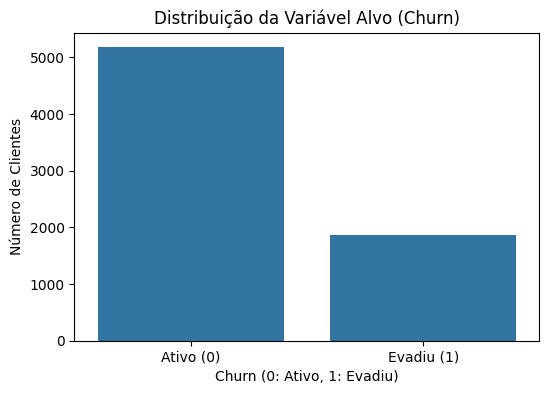

In [8]:
# Calcular contagem e proporção em uma única linha
churn_stats = df['Churn'].value_counts(normalize=False).to_frame('Contagem')
churn_stats['Proporção (%)'] = df['Churn'].value_counts(normalize=True) * 100

print(churn_stats)

# Visualizar a distribuição das classes
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Distribuição da Variável Alvo (Churn)')
plt.xlabel('Churn (0: Ativo, 1: Evadiu)')
plt.ylabel('Número de Clientes')
plt.xticks([0, 1], ['Ativo (0)', 'Evadiu (1)'])
plt.show()

Há um desequilíbrio significativo entre as classes "Ativo" e "Evadiu". A classe majoritária (clientes ativos) representa aproximadamente 73.5% do dataset, enquanto a classe minoritária (clientes que evadiram) representa apenas cerca de 26.5%.

**Impacto na modelagem preditiva:**

Este desequilíbrio pode impactar o desempenho dos modelos preditivos. Modelos treinados em datasets desbalanceados tendem a ser enviesados para a classe majoritária, o que significa que eles podem ter uma alta acurácia geral (por acertarem a maioria dos casos da classe majoritária), mas podem ter um desempenho ruim na identificação da classe minoritária (os clientes que evadiram), que é a classe de maior interesse para este problema.

# Aplicação de SMOTE para balanceamento

In [9]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Separar features e target
X = df_encoded.drop(columns='remainder__Churn')
y = df_encoded['remainder__Churn']

# Dividir em treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Original: X={X.shape}, y={y.shape}")
print(f"Treino: X={X_train.shape}, y={y_train.shape}")
print(f"Teste:  X={X_test.shape}, y={y_test.shape}")

# Aplicar SMOTE no treino
X_train_res, y_train_res = SMOTE(random_state=42).fit_resample(X_train, y_train)

# Mostrar distribuição após balanceamento
print("\nDistribuição no treino após SMOTE:")
print(y_train_res.value_counts())


Original: X=(7043, 42), y=(7043,)
Treino: X=(4930, 42), y=(4930,)
Teste:  X=(2113, 42), y=(2113,)

Distribuição no treino após SMOTE:
remainder__Churn
0.0    3622
1.0    3622
Name: count, dtype: int64


Primeiro, separamos as variáveis independentes (X) da variável alvo (y), que representa o Churn. Em seguida, realizamos a divisão dos dados em treino e teste, utilizando a técnica de estratificação (stratify=y) para manter a proporção original das classes em ambos os conjuntos.

No passo seguinte, aplicamos o SMOTE (Synthetic Minority Over-sampling Technique) apenas sobre o conjunto de treino. Essa técnica gera exemplos sintéticos da classe minoritária, em vez de apenas replicá-los, permitindo que o modelo aprenda de forma mais equilibrada e reduzindo o risco de overfitting.

Após a aplicação do SMOTE, verificamos a nova distribuição de classes, que passa a ser balanceada. Isso garante que o modelo não seja enviesado em favor da classe majoritária e que possa identificar de forma mais eficiente os clientes com maior propensão a evasão.

### Avaliando os resultados:

No dataset original, existiam 7043 clientes e 42 variáveis (features).

A divisão estratificada garantiu que o treino ficasse com 4930 clientes e o teste com 2113, mantendo a proporção de churn original.

Após o SMOTE, o conjunto de treino ficou balanceado:

* 3622 clientes ativos (classe 0)

* 3622 clientes evadidos (classe 1)

Ou seja, agora o modelo vai aprender com a mesma quantidade de exemplos das duas classes, reduzindo o viés em favor da classe majoritária.

### Visualizando o antes e depois SMOTE:

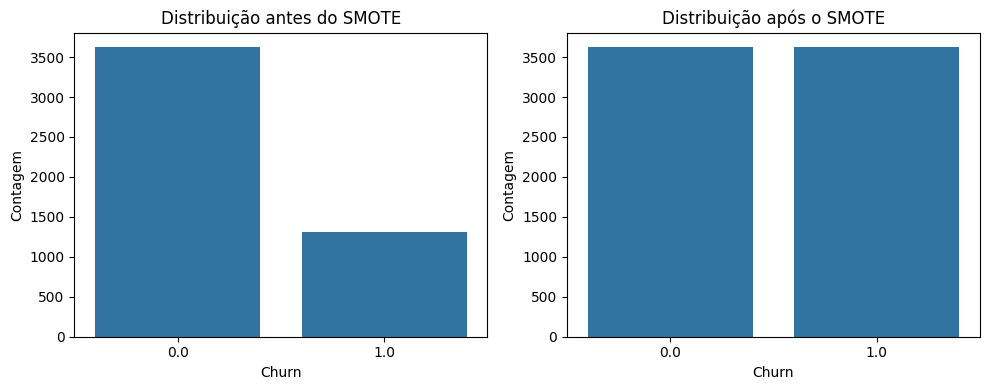

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Antes do SMOTE
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title("Distribuição antes do SMOTE")
axes[0].set_xlabel("Churn")
axes[0].set_ylabel("Contagem")

# Depois do SMOTE
sns.countplot(x=y_train_res, ax=axes[1])
axes[1].set_title("Distribuição após o SMOTE")
axes[1].set_xlabel("Churn")
axes[1].set_ylabel("Contagem")

plt.tight_layout()
plt.show()


# Padronização dos Dados Numéricos

**Por que normalizar/padronizar?**

Algoritmos baseados em distância (como KNN, SVM) ou gradiente (como Regressão Logística, Redes Neurais) calculam distâncias entre pontos ou dependem da magnitude dos valores das features. Se as features tiverem escalas muito diferentes (por exemplo, uma feature com valores entre 0-1 e outra com valores entre 1000-100000), as features com maior magnitude podem dominar o cálculo da distância ou o processo de otimização do modelo, levando a resultados subótimos.

A normalização (escalar valores para um intervalo específico, geralmente entre 0 e 1) ou a padronização (transformar os dados para ter média 0 e desvio padrão 1) garante que todas as features contribuam igualmente para o modelo.

Como o objetivo é construir um pipeline robusto e provavelmente exploraremos diferentes tipos de modelos (incluindo aqueles sensíveis à escala), é uma boa prática aplicar a padronização ou normalização nos dados numéricos após o One-Hot Encoding e o balanceamento.

In [11]:
from sklearn.preprocessing import StandardScaler

# Identificar as colunas numéricas já no dataset transformado
numeric_cols_encoded = [col for col in X_train_res.columns if col.startswith('remainder__')]
print(f"Colunas numéricas para padronização: {numeric_cols_encoded}")

# Criar scaler
scaler = StandardScaler()

# Fit no treino balanceado e transformar
X_train_res.loc[:, numeric_cols_encoded] = scaler.fit_transform(X_train_res[numeric_cols_encoded])

# Transformar o conjunto de teste
X_test.loc[:, numeric_cols_encoded] = scaler.transform(X_test[numeric_cols_encoded])

# Verificação
print("\nX_train_res (após padronização):")
display(X_train_res.head())
print("\nX_test (após padronização):")
display(X_test.head())


Colunas numéricas para padronização: ['remainder__maior_65_anos', 'remainder__possui_parceiro', 'remainder__dependentes', 'remainder__tempo_contrato_meses', 'remainder__servico_telefonico', 'remainder__fatura_online', 'remainder__cobranca_mensal', 'remainder__cobranca_total', 'remainder__num_servicos']

X_train_res (após padronização):


,ohe__genero_cliente_Female,ohe__genero_cliente_Male,ohe__mais_de_uma_linha_telefonica_No,ohe__mais_de_uma_linha_telefonica_No phone service,ohe__mais_de_uma_linha_telefonica_Yes,ohe__servico_internet_DSL,ohe__servico_internet_Fiber optic,ohe__servico_internet_No,ohe__servico_seguranca_online_No,ohe__servico_seguranca_online_No internet service,...,ohe__forma_de_pagamento_Mailed check,remainder__maior_65_anos,remainder__possui_parceiro,remainder__dependentes,remainder__tempo_contrato_meses,remainder__servico_telefonico,remainder__fatura_online,remainder__cobranca_mensal,remainder__cobranca_total,remainder__num_servicos
0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,-0.522804,-0.919609,-0.619692,-0.565292,0.314032,-1.426371,0.289833,-0.421429,-0.714307
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,-0.522804,-0.919609,-0.619692,-0.941259,0.314032,0.755166,0.064650,-0.774649,0.328355
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,-0.522804,1.190908,-0.619692,0.311963,0.314032,0.755166,0.246193,0.247564,-0.714307
3,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.522804,1.190908,-0.619692,1.272767,0.314032,0.755166,0.626736,1.308992,1.892349
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,-0.522804,-0.919609,-0.619692,-1.066581,0.314032,0.755166,-0.647559,-0.881374,-0.714307



X_test (após padronização):


,ohe__genero_cliente_Female,ohe__genero_cliente_Male,ohe__mais_de_uma_linha_telefonica_No,ohe__mais_de_uma_linha_telefonica_No phone service,ohe__mais_de_uma_linha_telefonica_Yes,ohe__servico_internet_DSL,ohe__servico_internet_Fiber optic,ohe__servico_internet_No,ohe__servico_seguranca_online_No,ohe__servico_seguranca_online_No internet service,...,ohe__forma_de_pagamento_Mailed check,remainder__maior_65_anos,remainder__possui_parceiro,remainder__dependentes,remainder__tempo_contrato_meses,remainder__servico_telefonico,remainder__fatura_online,remainder__cobranca_mensal,remainder__cobranca_total,remainder__num_servicos
4839,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,2.178717,1.190908,-0.619692,1.690507,0.314032,0.755166,0.748928,1.876374,0.328355
6844,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.522804,1.190908,1.755666,0.562608,0.314032,0.755166,-0.273998,0.217799,0.328355
648,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,-0.522804,-0.919609,-0.619692,-0.857711,0.314032,0.755166,0.424245,-0.692415,-0.714307
413,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,-0.522804,1.190908,1.755666,1.774056,0.314032,0.755166,-1.708889,-0.291244,-1.235638
992,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,-0.522804,-0.919609,-0.619692,-0.607066,-3.358752,-1.426371,-1.361513,-0.770177,-0.714307


# Análise de Correlação e Seleção de Variáveis

Por temos muitas variáveis, o heatmap ficaria muito “poluído” e difícil de interpretar. Logo, optei por visualizá-lo de duas maneiras diferentes:
1. Filtrar apenas as top 10 variáveis mais correlacionadas com o target
2. Exibir um gráfico de barras que deixa claro quais variáveis têm maior impacto

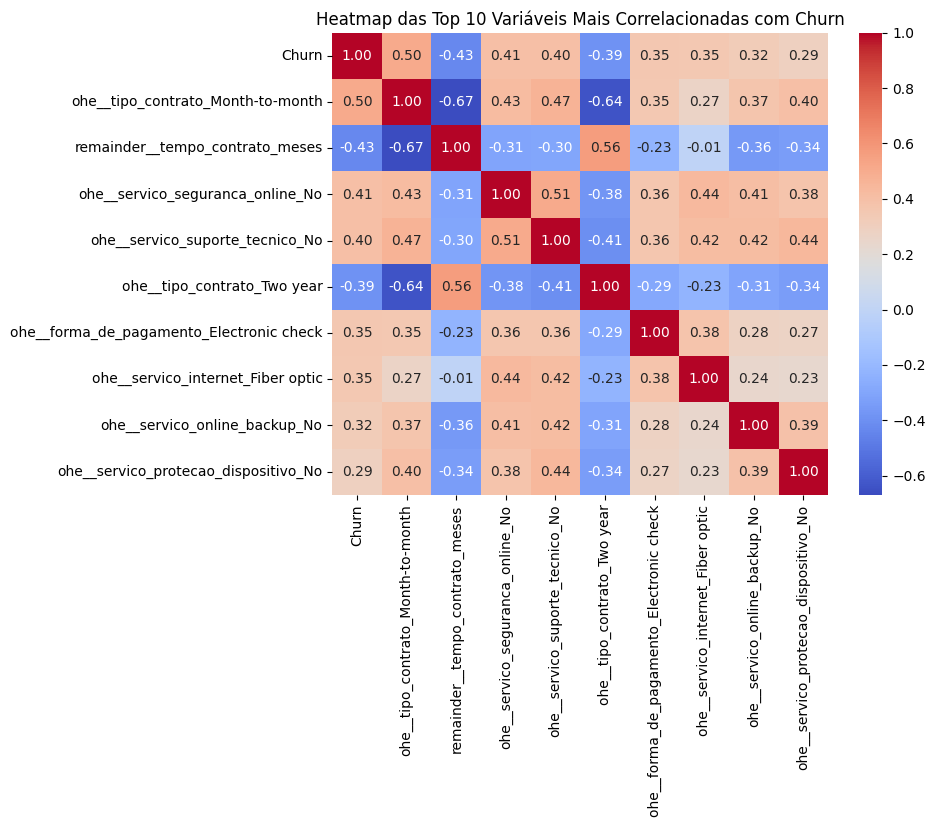

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Criar DataFrame temporário com features e target
df_corr = X_train_res.copy()
df_corr['Churn'] = y_train_res

# Calcular matriz de correlação
correlation_matrix = df_corr.corr()

# Ordenar variáveis pela correlação com o target
corr_with_target = correlation_matrix['Churn'].sort_values(ascending=False)

# 2️⃣ Heatmap: focar nas top N variáveis mais correlacionadas
top_n = 10
top_vars = corr_with_target.abs().sort_values(ascending=False).head(top_n).index

plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix.loc[top_vars, top_vars],
    annot=True, fmt=".2f", cmap='coolwarm'
)
plt.title(f'Heatmap das Top {top_n} Variáveis Mais Correlacionadas com Churn')
plt.show()


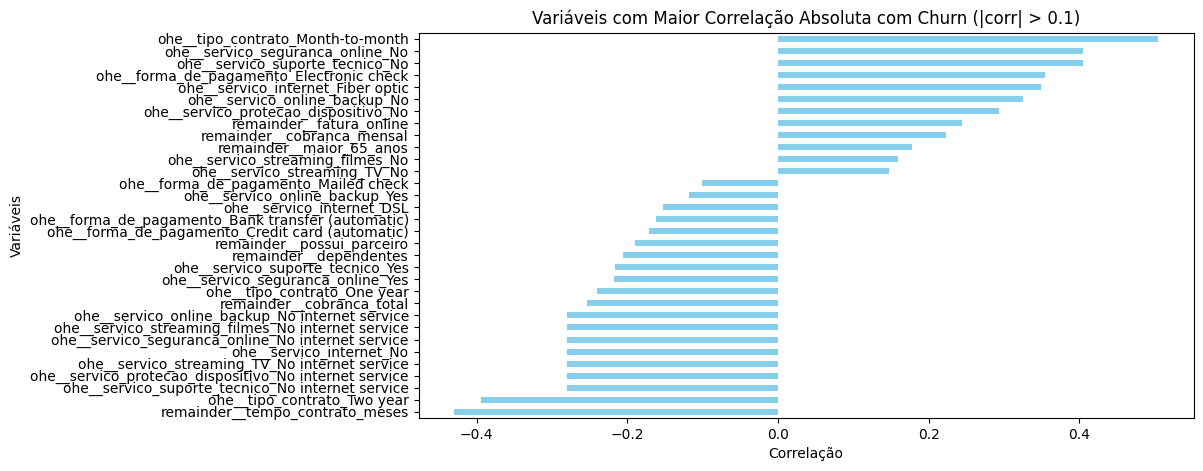

In [13]:
# 1️⃣ Gráfico de barras: mostrar apenas correlações fortes (abs > 0.1), exceto o próprio target
strong_corr = corr_with_target.drop('Churn')
strong_corr_filtered = strong_corr[abs(strong_corr) > 0.1]

plt.figure(figsize=(10, 5))
strong_corr_filtered.sort_values().plot(kind='barh', color='skyblue')
plt.title('Variáveis com Maior Correlação Absoluta com Churn (|corr| > 0.1)')
plt.xlabel('Correlação')
plt.ylabel('Variáveis')
plt.show()

Observações gerais:

Churn vs tipo de contrato Month-to-month: Correlação positiva forte (0.50).

* Clientes com contrato mensal têm maior propensão a evadir.

* É uma variável forte candidata para o modelo preditivo.

Churn vs tempo de contrato (meses): Correlação negativa moderada (-0.43).

* Quanto mais longo o tempo de contrato, menor a chance de evasão.

* Faz sentido lógico: clientes de longo prazo tendem a permanecer.

Churn vs serviços desativados

servico_segurança_online_No → 0.41

servico_suporte_tecnico_No → 0.40

servico_online_backup_No → 0.32

servico_protecao_dispositivo_No → 0.29

* Indica que clientes sem certos serviços têm maior risco de churn.

* Essas variáveis são relevantes para o modelo e podem ser agrupadas ou usadas individualmente.

Outras variáveis de contrato e pagamento

tipo_contrato_Two year → -0.39 (contrato longo diminui churn).

forma_de_pagamento_Electronic check → 0.35 (clientes que pagam por cheque eletrônico têm mais chance de churn).

servico_internet_Fiber optic → 0.35, indicando algum efeito na retenção (talvez relacionado a perfil de cliente ou custo).

🔹 Padrões interessantes:

Existe uma tendência clara: contratos mais curtos e clientes que não possuem serviços adicionais têm maior probabilidade de churn.

Alguns pares de variáveis mostram correlação entre si: por exemplo, tipo_contrato_Month-to-month e tipo_contrato_Two year têm correlação negativa (-0.64), o que é esperado.

Correlações muito altas entre variáveis independentes podem indicar multicolinearidade, importante para alguns modelos (como regressão logística).

🔹 Insights para o modelo preditivo:

Priorizar variáveis como: tipo_contrato_Month-to-month, remainder__tempo_contrato_meses, Serviços desativados (seguranca_online, suporte_tecnico, etc.), Forma de pagamento (Electronic check)

* Variáveis fortemente correlacionadas entre si podem ser avaliadas para reduzir dimensionalidade (PCA ou seleção de features).

* O heatmap indica que o modelo terá bons sinais preditivos, pois várias variáveis apresentam correlação moderada a forte com o target.

# Visualização: Tempo de Contrato e Churn

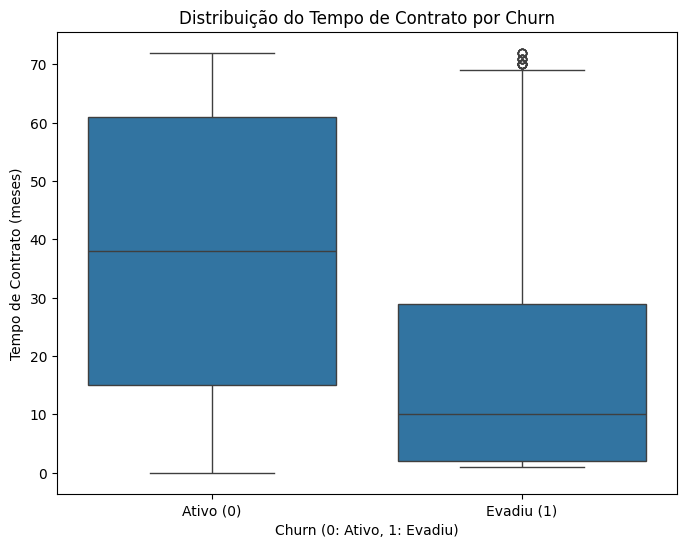

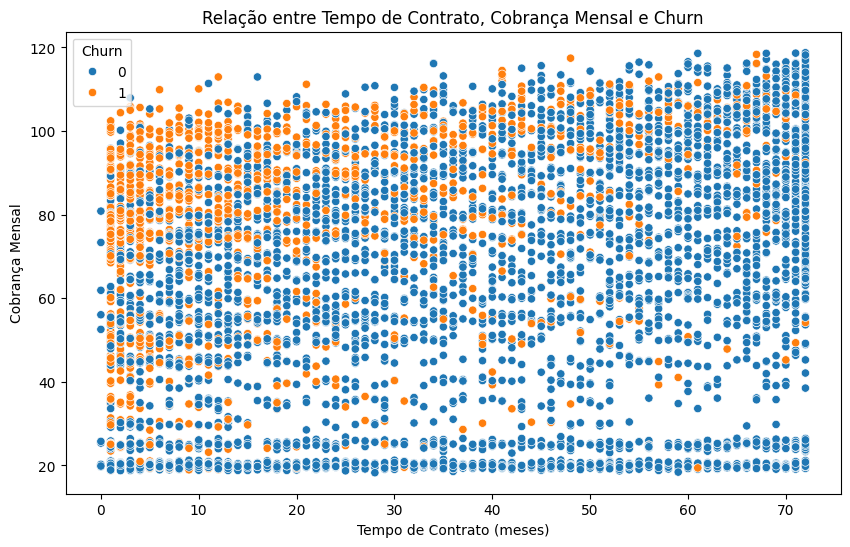

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot: Tempo de Contrato por Churn
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='tempo_contrato_meses', data=df)
plt.title('Distribuição do Tempo de Contrato por Churn')
plt.xlabel('Churn (0: Ativo, 1: Evadiu)')
plt.ylabel('Tempo de Contrato (meses)')
plt.xticks([0, 1], ['Ativo (0)', 'Evadiu (1)'])
plt.show()

# Scatter plot: Tempo de Contrato vs. Cobrança Mensal por Churn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tempo_contrato_meses', y='cobranca_mensal', hue='Churn', data=df)
plt.title('Relação entre Tempo de Contrato, Cobrança Mensal e Churn')
plt.xlabel('Tempo de Contrato (meses)')
plt.ylabel('Cobrança Mensal')
plt.show()

# Visualização: Cobrança Total e Churn

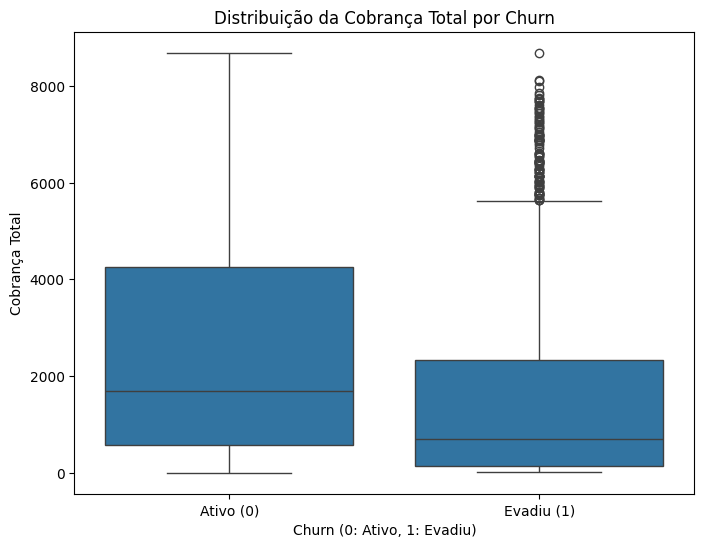

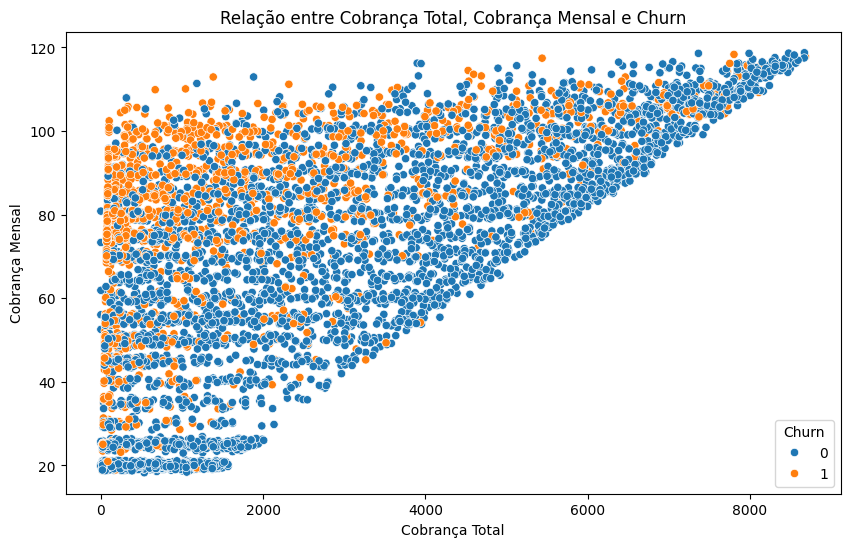

In [25]:
# Boxplot: Cobrança Total por Churn
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='cobranca_total', data=df)
plt.title('Distribuição da Cobrança Total por Churn')
plt.xlabel('Churn (0: Ativo, 1: Evadiu)')
plt.ylabel('Cobrança Total')
plt.xticks([0, 1], ['Ativo (0)', 'Evadiu (1)'])
plt.show()

# Scatter plot: Cobrança Total vs. Cobrança Mensal por Churn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cobranca_total', y='cobranca_mensal', hue='Churn', data=df)
plt.title('Relação entre Cobrança Total, Cobrança Mensal e Churn')
plt.xlabel('Cobrança Total')
plt.ylabel('Cobrança Mensal')
plt.show()

# Divisão do Conjunto de Dados em Treino e Teste

In [26]:
from sklearn.model_selection import train_test_split

# Separar features (X) e target (y)
X = df_encoded.drop(columns='remainder__Churn')
y = df_encoded['remainder__Churn']

# Dividir em treino e teste (70% treino, 30% teste) com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Shape do conjunto de treino (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Shape do conjunto de teste (X_test, y_test): {X_test.shape}, {y_test.shape}")

Shape do conjunto de treino (X_train, y_train): (4930, 42), (4930,)
Shape do conjunto de teste (X_test, y_test): (2113, 42), (2113,)


# Treinamento do Modelo de Regressão Logística

A Regressão Logística é um modelo linear que estima a probabilidade de um evento ocorrer (neste caso, o Churn) com base em uma função logística. É um modelo simples, interpretável e um bom ponto de partida para problemas de classificação. A Regressão Logística é sensível à escala das features, por isso, é recomendável aplicar a normalização (como a padronização que já fizemos) antes de treiná-la.


 Avaliação do Modelo de Regressão Logística:
Acurácia: 0.2664
Precisão: 0.2658
Recall: 1.0000
F1-Score: 0.4199
AUC-ROC: 0.4342

 Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00      1552
         1.0       0.27      1.00      0.42       561

    accuracy                           0.27      2113
   macro avg       0.63      0.50      0.21      2113
weighted avg       0.81      0.27      0.11      2113



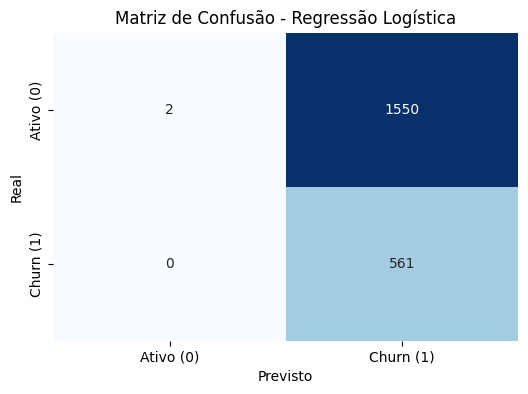

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

# Inicializar e treinar o modelo
log_reg_model = LogisticRegression(
    random_state=42,
    solver='liblinear'  # solver bom para datasets pequenos/médios
)
log_reg_model.fit(X_train_res, y_train_res)

# Prever no conjunto de teste
y_pred_log_reg = log_reg_model.predict(X_test)
y_proba_log_reg = log_reg_model.predict_proba(X_test)[:, 1]

# Avaliar o modelo
metrics = {
    "Acurácia": accuracy_score(y_test, y_pred_log_reg),
    "Precisão": precision_score(y_test, y_pred_log_reg),
    "Recall": recall_score(y_test, y_pred_log_reg),
    "F1-Score": f1_score(y_test, y_pred_log_reg),
    "AUC-ROC": roc_auc_score(y_test, y_proba_log_reg)
}

print("\n Avaliação do Modelo de Regressão Logística:")
for m, v in metrics.items():
    print(f"{m}: {v:.4f}")

print("\n Relatório de Classificação:")
print(classification_report(y_test, y_pred_log_reg))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_log_reg)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Ativo (0)", "Churn (1)"],
            yticklabels=["Ativo (0)", "Churn (1)"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Regressão Logística")
plt.show()

# Treinamento do Modelo de Árvore de Decisão

A Árvore de Decisão é um modelo não linear que divide os dados em subconjuntos com base nos valores das features, criando uma estrutura em forma de árvore. É fácil de entender e visualizar, e pode capturar interações complexas entre as features. Árvores de Decisão não são sensíveis à escala das features, portanto, a normalização não é estritamente necessária para este modelo, mas iremos utilizar também o modelo padronizado.

Fitting 5 folds for each of 160 candidates, totalling 800 fits

 Melhor combinação de hiperparâmetros encontrada:
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}

 Avaliação do Melhor Modelo de Árvore de Decisão:
Acurácia : 0.7463
Precisão : 0.5229
Recall   : 0.5098
F1-Score : 0.5162
AUC-ROC  : 0.6945


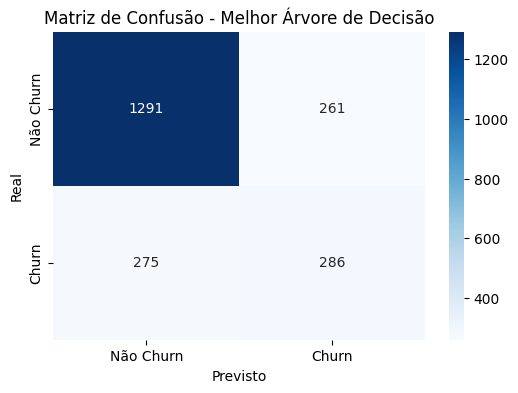

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Definição do modelo base
dec_tree = DecisionTreeClassifier(random_state=42)

# Definição do grid de hiperparâmetros
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 10, 20, 50],
    'min_samples_leaf': [1, 5, 10, 20],
    'criterion': ['gini', 'entropy']
}

# Configuração do GridSearchCV
grid_search = GridSearchCV(
    estimator=dec_tree,
    param_grid=param_grid,
    scoring='f1',   # usamos F1 para balancear precisão e recall
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Treinamento com os dados balanceados
grid_search.fit(X_train_res, y_train_res)

# Melhor modelo
best_dec_tree = grid_search.best_estimator_
print("\n Melhor combinação de hiperparâmetros encontrada:")
print(grid_search.best_params_)

# Avaliação no conjunto de teste
y_pred_best = best_dec_tree.predict(X_test)
y_proba_best = best_dec_tree.predict_proba(X_test)[:, 1]

print("\n Avaliação do Melhor Modelo de Árvore de Decisão:")
print(f"Acurácia : {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Precisão : {precision_score(y_test, y_pred_best):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_best):.4f}")
print(f"F1-Score : {f1_score(y_test, y_pred_best):.4f}")
print(f"AUC-ROC  : {roc_auc_score(y_test, y_proba_best):.4f}")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Não Churn", "Churn"],
            yticklabels=["Não Churn", "Churn"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Melhor Árvore de Decisão")
plt.show()


# Comparando os modelos


 Comparação de Modelos:
                Modelo  Acurácia  Precisão    Recall  F1-Score   AUC-ROC
0  Regressão Logística  0.266446  0.265751  1.000000  0.419910  0.434168
1    Árvore de Decisão  0.746332  0.522852  0.509804  0.516245  0.694544


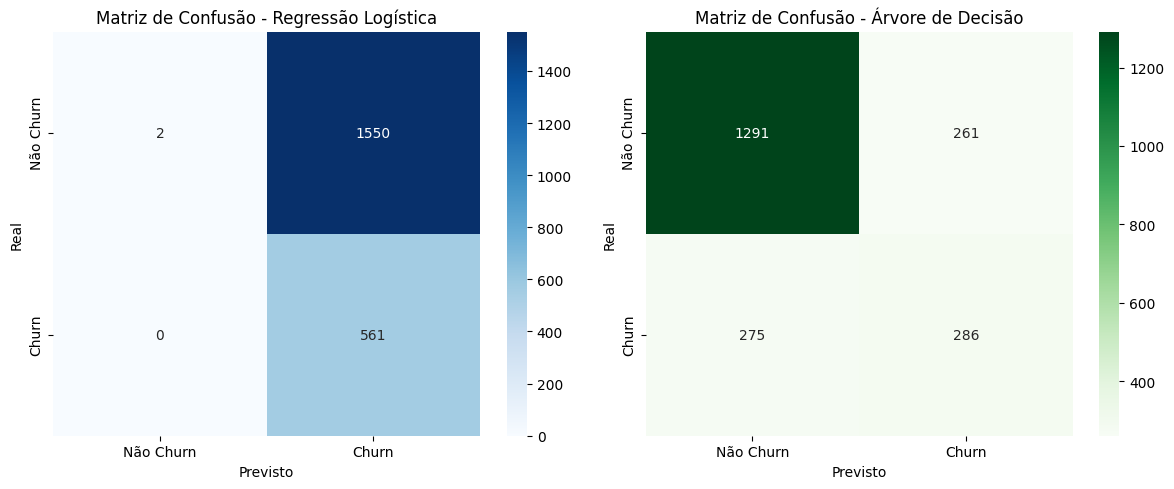

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# =============================
# 1. Avaliação Regressão Logística
# =============================
y_pred_log = log_reg_model.predict(X_test)
y_proba_log = log_reg_model.predict_proba(X_test)[:, 1]

metrics_log = {
    "Modelo": "Regressão Logística",
    "Acurácia": accuracy_score(y_test, y_pred_log),
    "Precisão": precision_score(y_test, y_pred_log),
    "Recall": recall_score(y_test, y_pred_log),
    "F1-Score": f1_score(y_test, y_pred_log),
    "AUC-ROC": roc_auc_score(y_test, y_proba_log)
}

# =============================
# 2. Avaliação Árvore de Decisão Otimizada
# =============================
y_pred_tree = best_dec_tree.predict(X_test)
y_proba_tree = best_dec_tree.predict_proba(X_test)[:, 1]

metrics_tree = {
    "Modelo": "Árvore de Decisão",
    "Acurácia": accuracy_score(y_test, y_pred_tree),
    "Precisão": precision_score(y_test, y_pred_tree),
    "Recall": recall_score(y_test, y_pred_tree),
    "F1-Score": f1_score(y_test, y_pred_tree),
    "AUC-ROC": roc_auc_score(y_test, y_proba_tree)
}

# =============================
# 3. Comparação das Métricas
# =============================
import pandas as pd
df_comparacao = pd.DataFrame([metrics_log, metrics_tree])
print("\n Comparação de Modelos:")
print(df_comparacao)

# =============================
# 4. Visualização - Matrizes de Confusão
# =============================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Regressão Logística
cm_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Não Churn", "Churn"],
            yticklabels=["Não Churn", "Churn"],
            ax=axes[0])
axes[0].set_title("Matriz de Confusão - Regressão Logística")
axes[0].set_xlabel("Previsto")
axes[0].set_ylabel("Real")

# Árvore de Decisão
cm_tree = confusion_matrix(y_test, y_pred_tree)
sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Não Churn", "Churn"],
            yticklabels=["Não Churn", "Churn"],
            ax=axes[1])
axes[1].set_title("Matriz de Confusão - Árvore de Decisão")
axes[1].set_xlabel("Previsto")
axes[1].set_ylabel("Real")

plt.tight_layout()
plt.show()


# Treinamento do Modelo K-Nearest Neighbors (KNN)

K-Nearest Neighbors (KNN): É um algoritmo simples e não paramétrico que classifica um ponto de dados com base na maioria das classes de seus "k" vizinhos mais próximos no espaço de features. O KNN é sensível à escala das features, portanto, utilizaremos os dados padronizados para este modelo.

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Função para avaliar modelos
def avaliar_modelo(nome, modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]

    resultados = {
        "Modelo": nome,
        "Acurácia": accuracy_score(y_test, y_pred),
        "Precisão": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "AUC-ROC": roc_auc_score(y_test, y_proba)
    }

    print(f"\n--- {nome} ---")
    print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))
    print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

    return resultados

# Definir parâmetros para busca
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "metric": ["minkowski", "euclidean", "manhattan"]
}

# GridSearchCV para encontrar os melhores parâmetros
grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    scoring="f1", # pode trocar para 'roc_auc' ou 'accuracy'
    n_jobs=-1
)

# Treinar com os dados balanceados e padronizados
grid_knn.fit(X_train_res, y_train_res)

print("Melhores parâmetros encontrados:", grid_knn.best_params_)

# Avaliar o modelo otimizado
resultados_knn = avaliar_modelo("KNN Otimizado", grid_knn.best_estimator_, X_test, y_test)

# Converter resultados em DataFrame (para comparar com outros modelos depois)
df_resultados = pd.DataFrame([resultados_knn])
print("\nResumo de Resultados:\n", df_resultados)


Melhores parâmetros encontrados: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

--- KNN Otimizado ---
Matriz de Confusão:
 [[1369  183]
 [ 369  192]]

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.79      0.88      0.83      1552
         1.0       0.51      0.34      0.41       561

    accuracy                           0.74      2113
   macro avg       0.65      0.61      0.62      2113
weighted avg       0.71      0.74      0.72      2113


Resumo de Resultados:
           Modelo  Acurácia  Precisão    Recall  F1-Score   AUC-ROC
0  KNN Otimizado   0.73876     0.512  0.342246  0.410256  0.717979


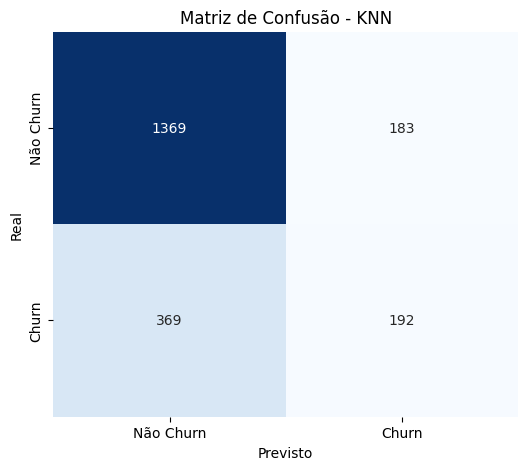

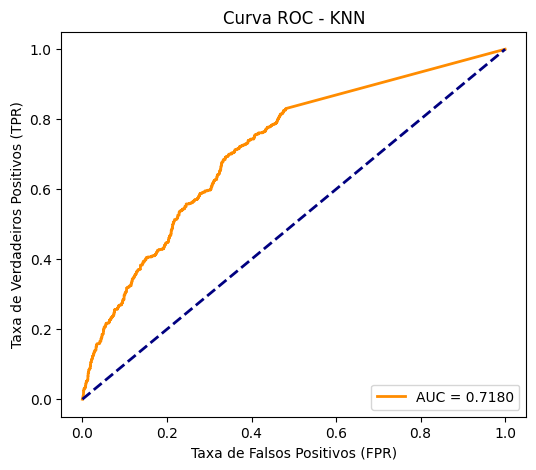

In [39]:
from sklearn.metrics import roc_curve, auc

# 1. Matriz de Confusão
def plot_confusion_matrix(modelo, X_test, y_test, titulo="Matriz de Confusão - KNN"):
    y_pred = modelo.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Não Churn", "Churn"],
                yticklabels=["Não Churn", "Churn"])
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.title(titulo)
    plt.show()

# 2. Curva ROC
def plot_roc_curve(modelo, X_test, y_test, titulo="Curva ROC - KNN"):
    y_proba = modelo.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
    plt.xlabel("Taxa de Falsos Positivos (FPR)")
    plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
    plt.title(titulo)
    plt.legend(loc="lower right")
    plt.show()

# Exemplo de uso (usando o KNN otimizado do GridSearchCV)
plot_confusion_matrix(grid_knn.best_estimator_, X_test, y_test)
plot_roc_curve(grid_knn.best_estimator_, X_test, y_test)


# Treinamento do Modelo Random Forest

Random Forest: É um modelo de ensemble que constrói várias árvores de decisão durante o treinamento e produz a classe que é a moda das classes (classificação) ou a previsão média (regressão) das árvores individuais. É robusto ao overfitting e geralmente tem bom desempenho. Random Forest não é sensível à escala das features, mas para consistência na comparação, utilizaremos também os dados padronizados.

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Função para avaliar o modelo
def avaliar_modelo(nome, modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]

    resultados = {
        "Modelo": nome,
        "Acurácia": accuracy_score(y_test, y_pred),
        "Precisão": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "AUC-ROC": roc_auc_score(y_test, y_proba)
    }

    print(f"\n--- {nome} ---")
    print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))
    print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

    return resultados

# 2. Grid de parâmetros para otimização
param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"]
}

# 3. GridSearchCV para Random Forest
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

# 4. Treinar o modelo otimizado
grid_rf.fit(X_train_res, y_train_res)
print("Melhores parâmetros encontrados:", grid_rf.best_params_)

# 5. Avaliar o modelo otimizado
resultados_rf = avaliar_modelo("Random Forest Otimizado", grid_rf.best_estimator_, X_test, y_test)

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
424 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py"

Melhores parâmetros encontrados: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}

--- Random Forest Otimizado ---
Matriz de Confusão:
 [[1249  303]
 [ 180  381]]

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.87      0.80      0.84      1552
         1.0       0.56      0.68      0.61       561

    accuracy                           0.77      2113
   macro avg       0.72      0.74      0.73      2113
weighted avg       0.79      0.77      0.78      2113



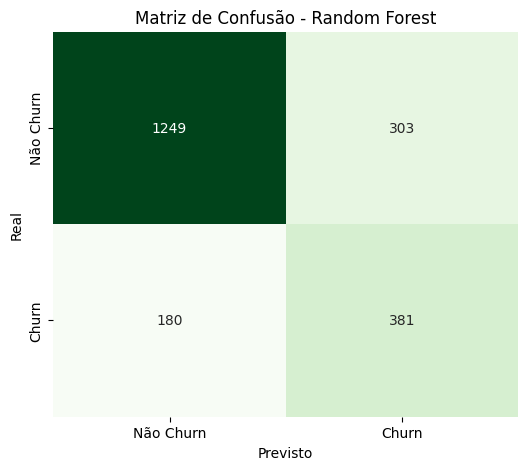

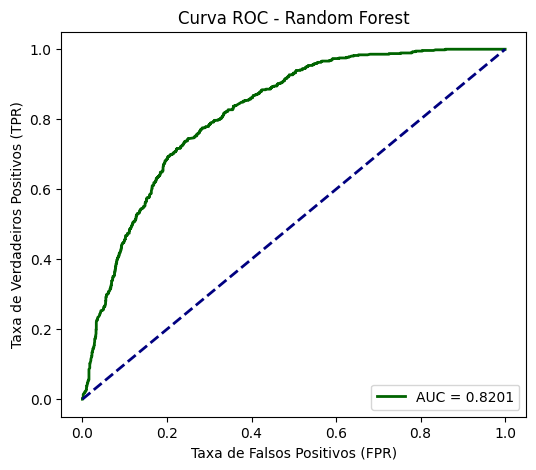

In [45]:
# 6. Visualização - Matriz de Confusão
def plot_confusion_matrix(modelo, X_test, y_test, titulo="Matriz de Confusão - Random Forest"):
    y_pred = modelo.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False,
                xticklabels=["Não Churn", "Churn"],
                yticklabels=["Não Churn", "Churn"])
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.title(titulo)
    plt.show()

# 7. Visualização - Curva ROC
def plot_roc_curve(modelo, X_test, y_test, titulo="Curva ROC - Random Forest"):
    y_proba = modelo.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color="darkgreen", lw=2, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
    plt.xlabel("Taxa de Falsos Positivos (FPR)")
    plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
    plt.title(titulo)
    plt.legend(loc="lower right")
    plt.show()

# 8. Executar visualizações
plot_confusion_matrix(grid_rf.best_estimator_, X_test, y_test)
plot_roc_curve(grid_rf.best_estimator_, X_test, y_test)

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# Métricas da Regressão Logística (obtidas da célula 321693ed)
metrics_log_reg = {
    "Modelo": "Regressão Logística",
    "Acurácia": accuracy_score(y_test, log_reg_model.predict(X_test)),
    "Precisão": precision_score(y_test, log_reg_model.predict(X_test)),
    "Recall": recall_score(y_test, log_reg_model.predict(X_test)),
    "F1-Score": f1_score(y_test, log_reg_model.predict(X_test)),
    "AUC-ROC": roc_auc_score(y_test, log_reg_model.predict_proba(X_test)[:, 1])
}

# Métricas da Árvore de Decisão (obtidas da célula 1830897e - usando o best_estimator_)
metrics_dec_tree = {
    "Modelo": "Árvore de Decisão Otimizada",
    "Acurácia": accuracy_score(y_test, best_dec_tree.predict(X_test)),
    "Precisão": precision_score(y_test, best_dec_tree.predict(X_test)),
    "Recall": recall_score(y_test, best_dec_tree.predict(X_test)),
    "F1-Score": f1_score(y_test, best_dec_tree.predict(X_test)),
    "AUC-ROC": roc_auc_score(y_test, best_dec_tree.predict_proba(X_test)[:, 1])
}

# Métricas do KNN (obtidas da célula 595acbd0 - usando o best_estimator_)
metrics_knn = {
    "Modelo": "KNN Otimizado",
    "Acurácia": accuracy_score(y_test, grid_knn.best_estimator_.predict(X_test)),
    "Precisão": precision_score(y_test, grid_knn.best_estimator_.predict(X_test)),
    "Recall": recall_score(y_test, grid_knn.best_estimator_.predict(X_test)),
    "F1-Score": f1_score(y_test, grid_knn.best_estimator_.predict(X_test)),
    "AUC-ROC": roc_auc_score(y_test, grid_knn.best_estimator_.predict_proba(X_test)[:, 1])
}

# Métricas do Random Forest (obtidas da célula 3717b77d - usando o best_estimator_)
# É necessário re-executar a célula 3717b77d para garantir que grid_rf.best_estimator_ está disponível
metrics_rf = {
    "Modelo": "Random Forest Otimizado",
    "Acurácia": accuracy_score(y_test, grid_rf.best_estimator_.predict(X_test)),
    "Precisão": precision_score(y_test, grid_rf.best_estimator_.predict(X_test)),
    "Recall": recall_score(y_test, grid_rf.best_estimator_.predict(X_test)),
    "F1-Score": f1_score(y_test, grid_rf.best_estimator_.predict(X_test)),
    "AUC-ROC": roc_auc_score(y_test, grid_rf.best_estimator_.predict_proba(X_test)[:, 1])
}


# Criar DataFrame com todas as métricas
df_comparacao_completa = pd.DataFrame([metrics_log_reg, metrics_dec_tree, metrics_knn, metrics_rf])

print("Tabela Comparativa de Métricas dos Modelos:")
display(df_comparacao_completa)

Tabela Comparativa de Métricas dos Modelos:


,Modelo,Acurácia,Precisão,Recall,F1-Score,AUC-ROC
0,Regressão Logística,0.266446,0.265751,1.000000,0.419910,0.434168
1,Árvore de Decisão Otimizada,0.746332,0.522852,0.509804,0.516245,0.694544
2,KNN Otimizado,0.738760,0.512000,0.342246,0.410256,0.717979
3,Random Forest Otimizado,0.771415,0.557018,0.679144,0.612048,0.820113


# Análise de Importância das Variáveis

In [49]:
# 1. Obter importância das variáveis do Random Forest otimizado
importancias = grid_rf.best_estimator_.feature_importances_

# 2. Criar DataFrame com nomes das features e suas importâncias
df_importancias = pd.DataFrame({
    "Variável": X_train_res.columns,  # nomes das features
    "Importância": importancias
})

# 3. Ordenar pelas mais importantes
df_importancias = df_importancias.sort_values(by="Importância", ascending=False)

# 4. Exibir tabela
print("Importância das Variáveis - Random Forest:")
print(df_importancias)


Importância das Variáveis - Random Forest:
                                             Variável  Importância
26                  ohe__tipo_contrato_Month-to-month     0.124659
31           ohe__forma_de_pagamento_Electronic check     0.095825
8                    ohe__servico_seguranca_online_No     0.076724
36                    remainder__tempo_contrato_meses     0.075532
17                    ohe__servico_suporte_tecnico_No     0.057400
40                          remainder__cobranca_total     0.056505
28                        ohe__tipo_contrato_Two year     0.045063
11                      ohe__servico_online_backup_No     0.041444
38                           remainder__fatura_online     0.041377
39                         remainder__cobranca_mensal     0.031055
6                   ohe__servico_internet_Fiber optic     0.029397
10                  ohe__servico_seguranca_online_Yes     0.026713
27                        ohe__tipo_contrato_One year     0.025731
14               oh

Top 5 Variáveis mais importantes - Random Forest:
                                    Variável  Importância
26         ohe__tipo_contrato_Month-to-month     0.124659
31  ohe__forma_de_pagamento_Electronic check     0.095825
8           ohe__servico_seguranca_online_No     0.076724
36           remainder__tempo_contrato_meses     0.075532
17           ohe__servico_suporte_tecnico_No     0.057400


/tmp/ipython-input-3468144613.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importância", y="Variável", data=df_top_importancias, palette="magma")


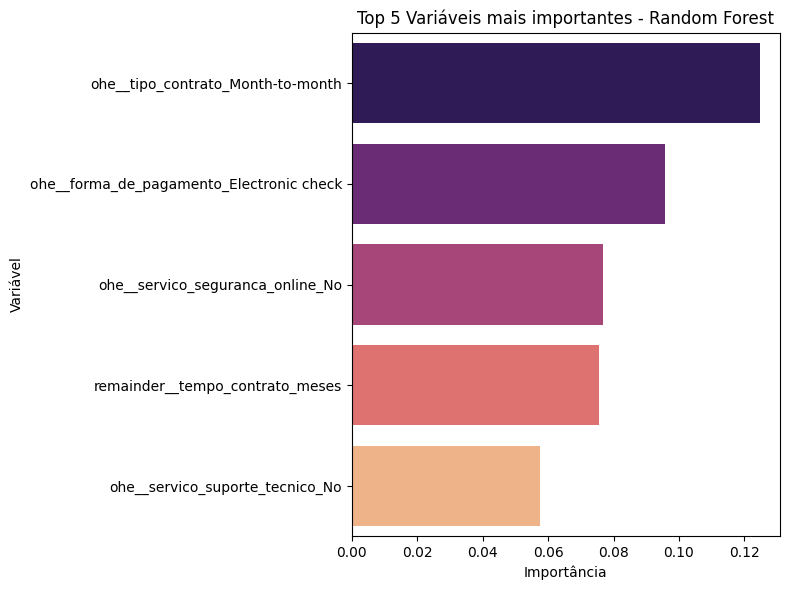

In [51]:
# Selecionar as 5 variáveis mais importantes
top_n = 5
df_top_importancias = df_importancias.head(top_n)

# Exibir tabela das top 5
print(f"Top {top_n} Variáveis mais importantes - Random Forest:")
print(df_top_importancias)

# Gráfico de barras das top 5 variáveis
plt.figure(figsize=(8,6))
sns.barplot(x="Importância", y="Variável", data=df_top_importancias, palette="magma")
plt.title(f"Top {top_n} Variáveis mais importantes - Random Forest")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()
